In [1]:
from shared import *

In [2]:
purchases_df = get_wearable_purchases_df()

In [3]:
wearable_types_df = get_wearable_types_df()

In [4]:
purchases_types_df = get_wearables_purchases_types_df(wearable_types_df, purchases_df)

In [5]:
market_cap_df = get_wearables_market_cap_df(wearable_types_df, purchases_df)

In [6]:
wearable_equipped_df = wearable_types_df
wearable_owners_equipped = []
i = 1
for block in RARITY_FARMING_BLOCKS:
    gotchis_wearables_df = get_gotchis_wearables_df(block)
    wearable_equipped_df = wearable_equipped_df.join(get_wearable_equipped_df(block, gotchis_wearables_df, wearable_types_df).rename(columns=lambda c: str(c) + '_rf' + str(i)), how='outer')
    wearable_owners_equipped += [[i, gotchis_wearables_df['owner.id'].str.lower().nunique()]]
    i += 1
wearable_owners_equipped_df = pd.DataFrame(wearable_owners_equipped, columns=['rfSeason', 'uniqueOwnersEquipped']).set_index('rfSeason')

# Aaavegotchi Wearables Market Dashboard

This dashboard was commissioned by the Aavegotchi DAO so that the Wearables Task Force (WTF) and other constituents can make well informed, data-driven decisions about future wearables emissions and other related matters. The following sections are available:

* [Volume](#Bazaar-Sales-Volume) - Bazaar sales volume for wearables
* [Prices](#Bazaar-Sales-Prices) - Median sale prices and market capitalization
* [Supply](#Wearables-Supply) - Available supply and slot distribution
* [Usage](#Wearables-Usage-for-Rarity-Farming) - Equipping of wearables for rarity farming

Data is updated approximately once every 24 hours. Please note that reports may require up to several minutes to load at times where the data is old and needs to be updated.

Created by MikeyJay. Source code is available on [GitHub](https://github.com/mikey-jay/aavegotchi-data-science/tree/wtf-binder).

In [7]:
get_page_header()


Using data from 2022-06-01 00:00 to 2023-05-31 23:59 UTC

In [8]:
column_name_mappings = {'name': 'Wearable', 'quantity': 'Total Volume (Units)', 'totalPrice': 'Total Volume (GHST)', 'rarity': 'Rarity', 'slotNames': 'Slot(s)', 'datePurchased': 'Date', 'startOfWeekPurchased': 'Week', 'yearMonthPurchased': 'Month'}
metrics = [column_name_mappings['quantity'], column_name_mappings['totalPrice']]

def get_pivot_by_column(column_name):
    return purchases_types_df.pivot_table(index=column_name,values=['quantity', 'totalPrice'],aggfunc=np.sum,margins=False).reset_index().rename(columns=column_name_mappings)

by_name_df = get_pivot_by_column('name')
by_slot_df = get_pivot_by_column('slotNames')
by_rarity_df = get_pivot_by_column('rarity')
total_volume_df = pd.DataFrame([[purchases_types_df['quantity'].sum(), purchases_types_df['totalPrice'].sum()]], columns=['Total Volume (Units)', 'Total Volume (GHST)'])
by_day_df = get_pivot_by_column('datePurchased')
by_week_df = get_pivot_by_column('startOfWeekPurchased')
by_month_df = get_pivot_by_column('yearMonthPurchased')

## Bazaar Sales Volume
### Total Volume

In [9]:
show_itable(total_volume_df)

### Volume Over Time
Incomplete weeks / months are ommitted.

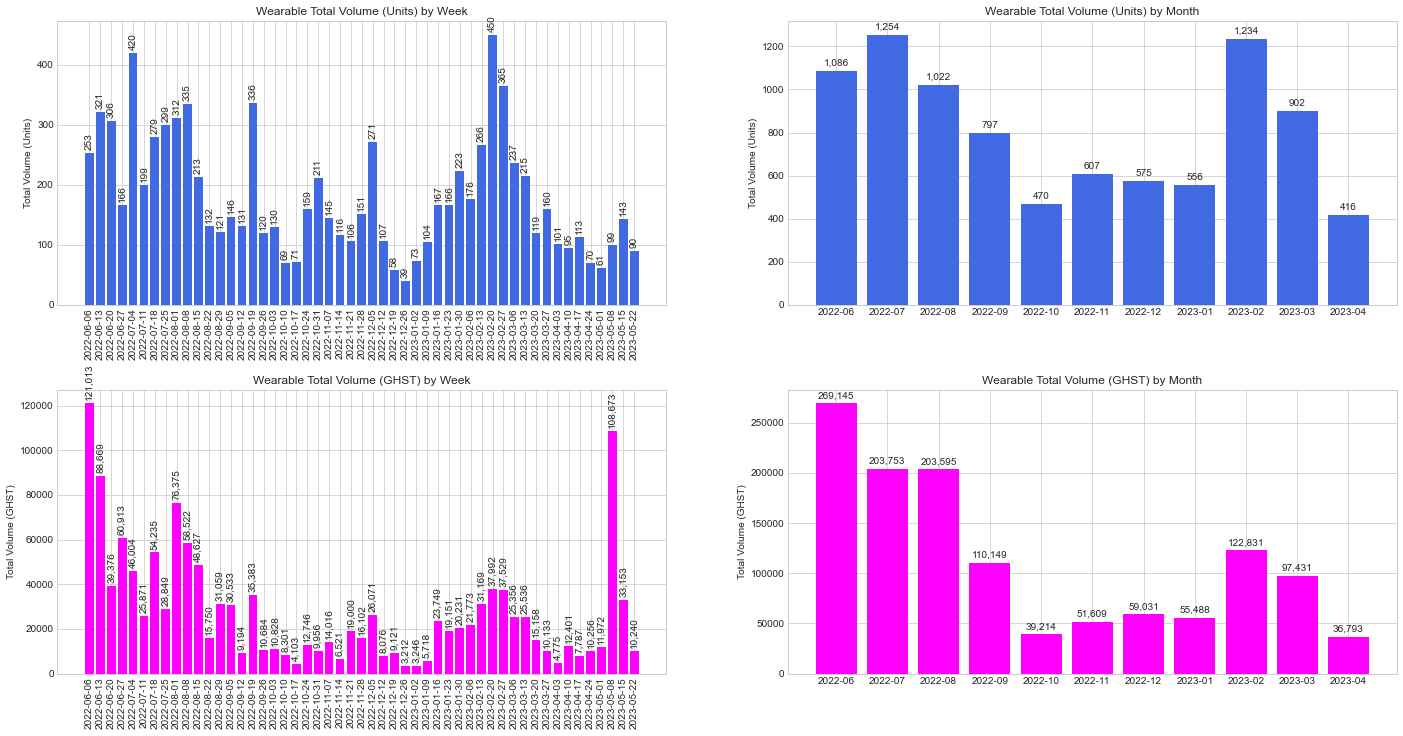

In [10]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(24,12)
fig.subplots_adjust(hspace=0.3)
# titles
dfs = [by_week_df.iloc[1:-1], by_month_df[:-1]]
x_cols = ['startOfWeekPurchased', 'yearMonthPurchased']
y_cols = ['quantity', 'totalPrice']
colors = ['royalBlue', 'magenta']

for row in [0,1]:
    for col in [0,1]:
        xcol = column_name_mappings[x_cols[col]]
        ycol = column_name_mappings[y_cols[row]]
        df = dfs[col]
        ax[row][col].set_title("Wearable {metric} by {interval}".format(metric=ycol, interval=xcol))
        ax[row][col].set_ylabel(ycol)
        ax[row][col].ticklabel_format(style="plain")
        plt.setp(ax[row][col].xaxis.get_majorticklabels(), rotation=-90 * (col - 1))
        bars = ax[row][col].bar(df[xcol], df[ycol], tick_label=df[xcol], color=colors[row], width=(0.8 if col == 1 else 0.8 * 7))
        for b in bars:
            height = b.get_height()
            ax[row][col].annotate('{:,.0f}'.format(height),
                rotation= (col - 1) * -90,
                xy=(b.get_x() + b.get_width() / 2, height),
                xytext=(0, 3), # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')     

### Volume by Wearable

In [11]:
show_itable_long(by_name_df, order=[[2, 'desc']])

### Volume by Slot

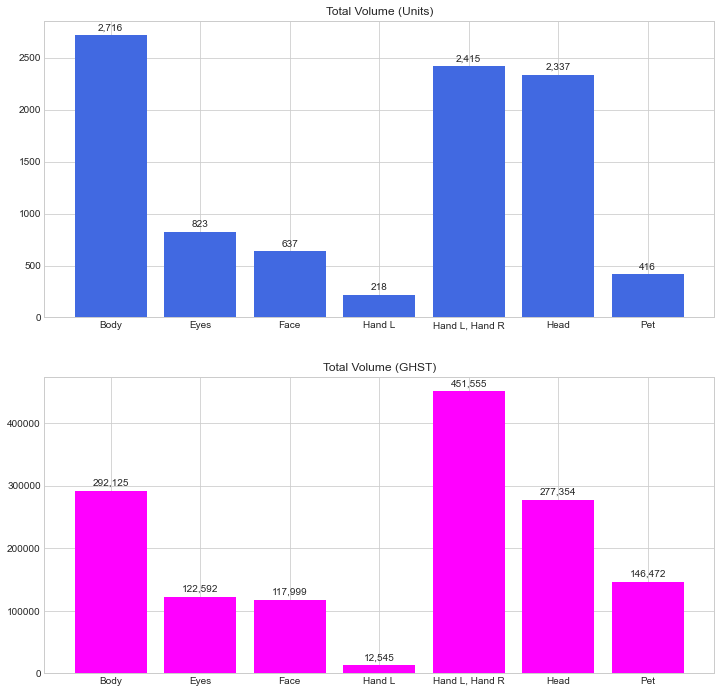

In [12]:
get_bar_charts(by_slot_df, column_name_mappings['slotNames'], metrics, colors)

### Volume by Rarity

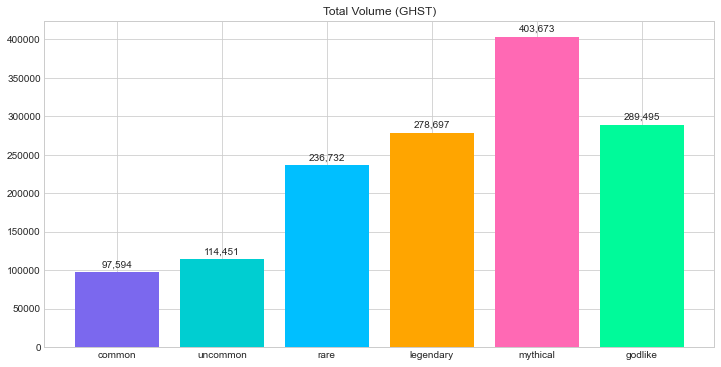

In [13]:
sorted_by_rarity_df = by_rarity_df.sort_values(column_name_mappings['quantity'], ascending=False)
rarity_colors = list(map(get_rarity_color, sorted_by_rarity_df[column_name_mappings['rarity']].to_list()))
get_bar_charts(sorted_by_rarity_df, column_name_mappings['rarity'], metrics[1:], [rarity_colors])

In [14]:
show_itable(by_rarity_df, order=[[2, 'desc']])

## Bazaar Sales Prices

In [15]:
column_name_mappings = {'name': 'Wearable', 'price': 'Median Price (GHST)', 'rarity': 'Rarity', 'slotNames': 'Slot(s)', 'datePurchased': 'Date', 'startOfWeekPurchased': 'Week', 'yearMonthPurchased': 'Month', 'lastPrice': 'Last Sale Price (GHST)', 'marketCap': 'Market Cap (GHST)', 'maxQuantity': 'Total Supply'}

def get_median_price_by_column(column_name):
    return purchases_types_df.pivot_table(index=column_name,values=['price'],aggfunc=np.median,margins=False).reset_index().rename(columns=column_name_mappings)
def get_market_cap_by_column(column_name):
    return market_cap_df.pivot_table(index=column_name,values=['marketCap'],aggfunc=np.sum,margins=False).reset_index().rename(columns=column_name_mappings)

price_by_name_df = get_median_price_by_column('name')
price_by_slot_df = get_median_price_by_column('slotNames')
price_by_rarity_df = get_median_price_by_column('rarity')
price_by_month_df = get_median_price_by_column('yearMonthPurchased')[:-1]
price_by_month_rarity_df = purchases_types_df.pivot_table(index='yearMonthPurchased', columns='rarity', values=['price'],aggfunc=np.median,margins=False).reset_index().rename(columns=column_name_mappings).fillna(0)[:-1]
total_market_cap_df = pd.DataFrame([market_cap_df['marketCap'].sum()], columns=["Market Cap (GHST)"])
cap_by_name_df = market_cap_df.pivot_table(index='name',values=['lastPrice', 'maxQuantity', 'marketCap'],aggfunc=np.sum,margins=False).reset_index().rename(columns=column_name_mappings)
cap_by_slot_df = get_market_cap_by_column('slotNames')
cap_by_rarity_df = get_market_cap_by_column('rarity')

### Median Price by Month and Rarity

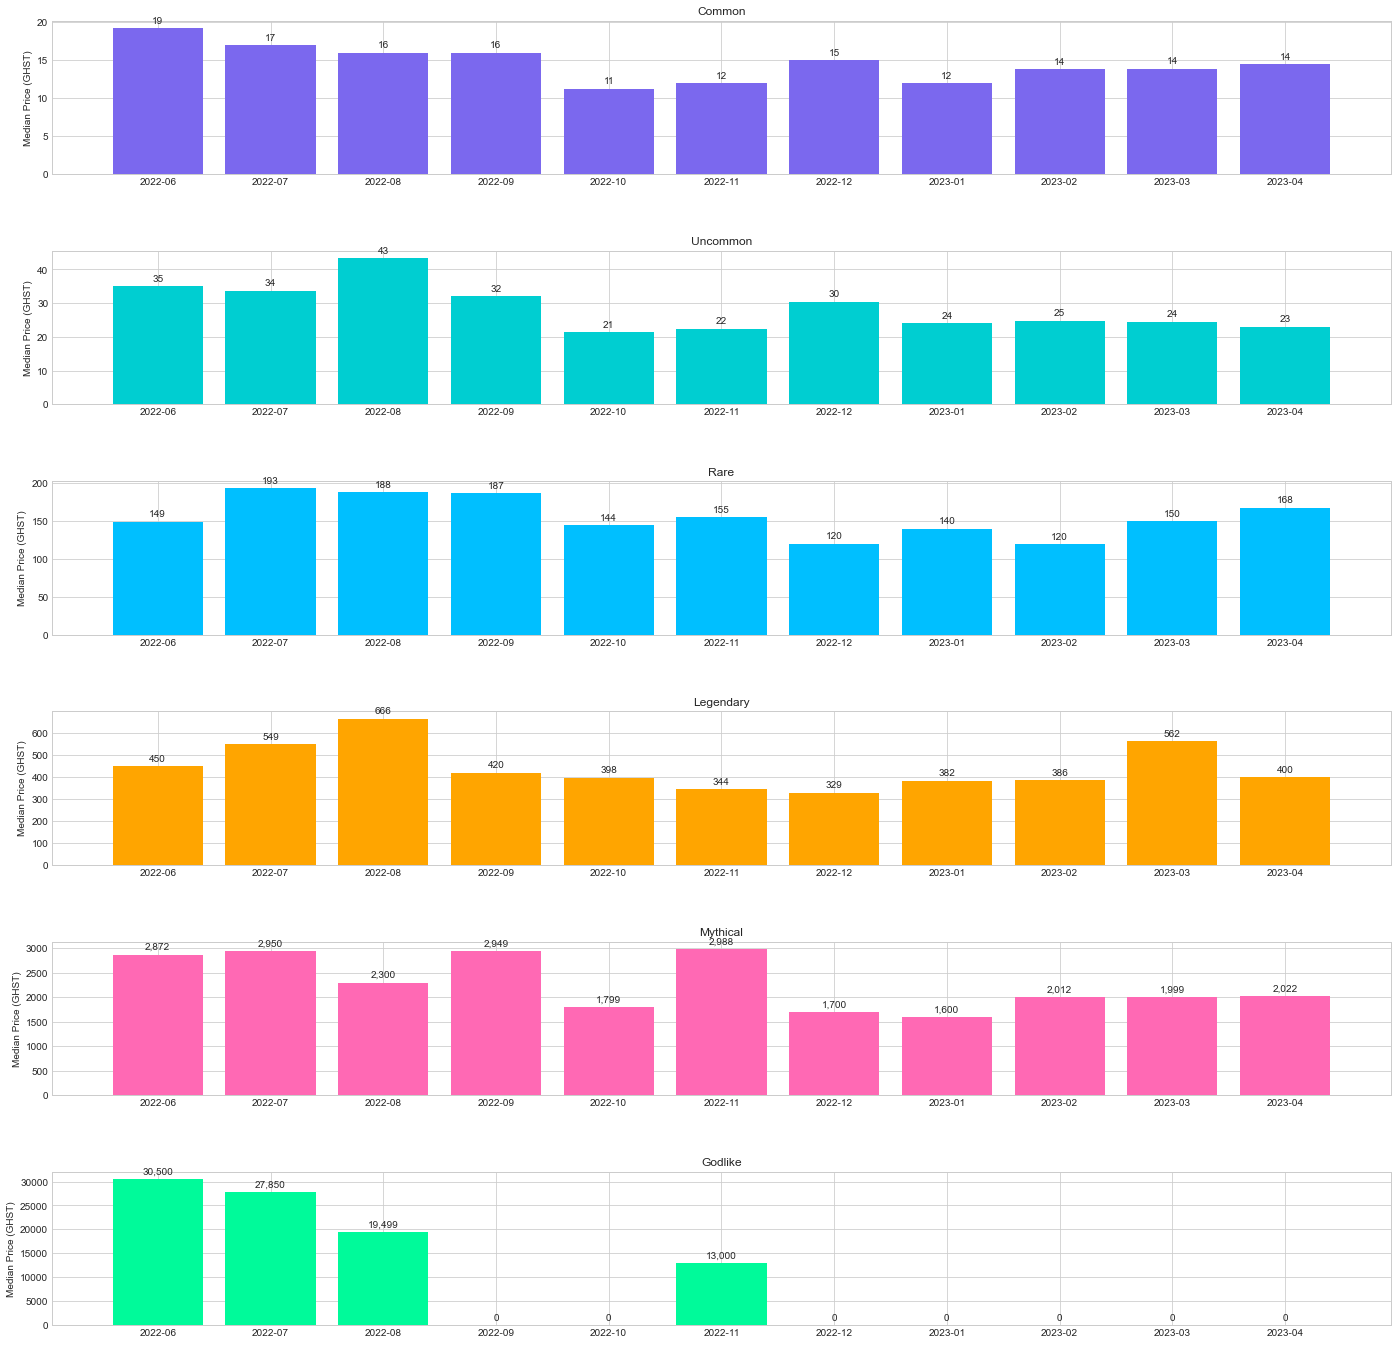

In [16]:
fig, axes = plt.subplots(6)
fig.set_size_inches(24,24)
fig.subplots_adjust(hspace=0.5)
# titles
xcol = column_name_mappings['yearMonthPurchased']
ycol = column_name_mappings['price']
rarities = ['common', 'uncommon', 'rare', 'legendary', 'mythical', 'godlike']
months = price_by_month_df[xcol]
for i in range(0,len(rarities)):
    rarity = rarities[i]
    ax = axes[i]
    ax.set_title("{r}".format(r=rarity).capitalize())
    ax.set_ylabel(ycol)
    bars = ax.bar(price_by_month_rarity_df[xcol], price_by_month_rarity_df[ycol][rarity], color=get_rarity_color(rarity))
    for b in bars:
        height = b.get_height()
        ax.annotate('{:,.0f}'.format(height),
        xy=(b.get_x() + b.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')            

### Median Price by Wearable

In [17]:
show_itable_long(price_by_name_df, order=[[1, 'asc']])

### Median Price by Slot

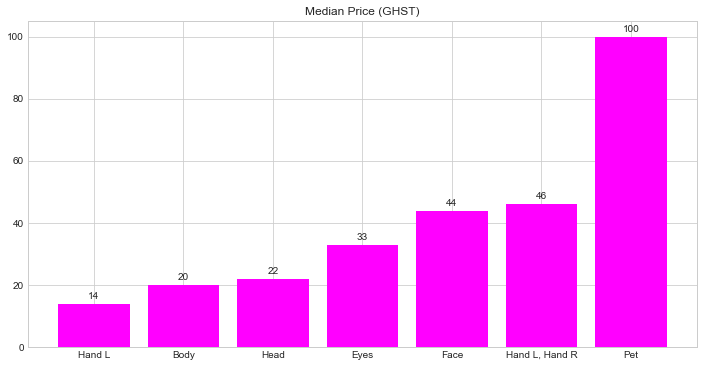

In [18]:
get_bar_charts(price_by_slot_df.sort_values(column_name_mappings['price']), column_name_mappings['slotNames'], [column_name_mappings['price']], [GHST_COLOR])

### Median Price by Rarity

In [19]:
show_itable(price_by_rarity_df, order=[[1, 'asc']])

### Total Market Cap

In [20]:
show_itable(total_market_cap_df)

Market Cap (GHST)
Loading... (need help?)


### Market Cap by Wearable

In [21]:
# need to reorder columns due to pandas pivot values column sorting issue: https://github.com/pandas-dev/pandas/issues/17041
show_itable_long(cap_by_name_df[[column_name_mappings['name'],column_name_mappings['lastPrice'],column_name_mappings['maxQuantity'],column_name_mappings['marketCap']]], order=[[3, 'desc']])

### Market Cap by Slot

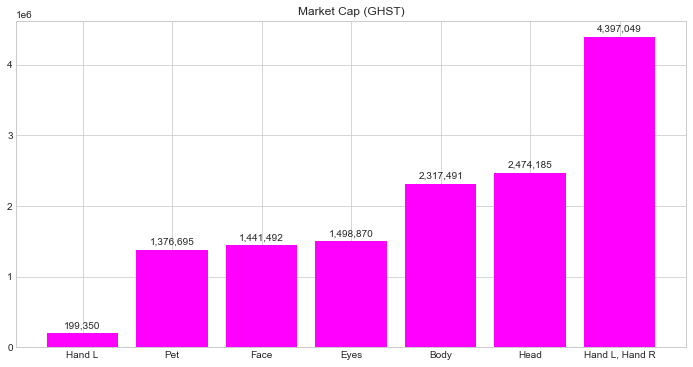

In [22]:
get_bar_charts(cap_by_slot_df.sort_values(column_name_mappings['marketCap']), column_name_mappings['slotNames'], [column_name_mappings['marketCap']], [GHST_COLOR])

### Market Cap by Rarity

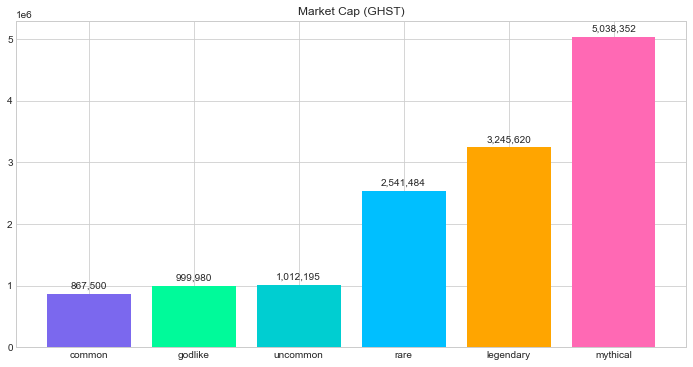

In [23]:
#show_itable(cap_by_rarity_df, order=[[1, 'desc']])
sorted_cap_by_rarity_df = cap_by_rarity_df.sort_values(column_name_mappings['marketCap'])
rarity_colors = list(map(get_rarity_color, sorted_cap_by_rarity_df[column_name_mappings['rarity']].to_list()))
get_bar_charts(sorted_cap_by_rarity_df, column_name_mappings['rarity'], [column_name_mappings['marketCap']], [rarity_colors])

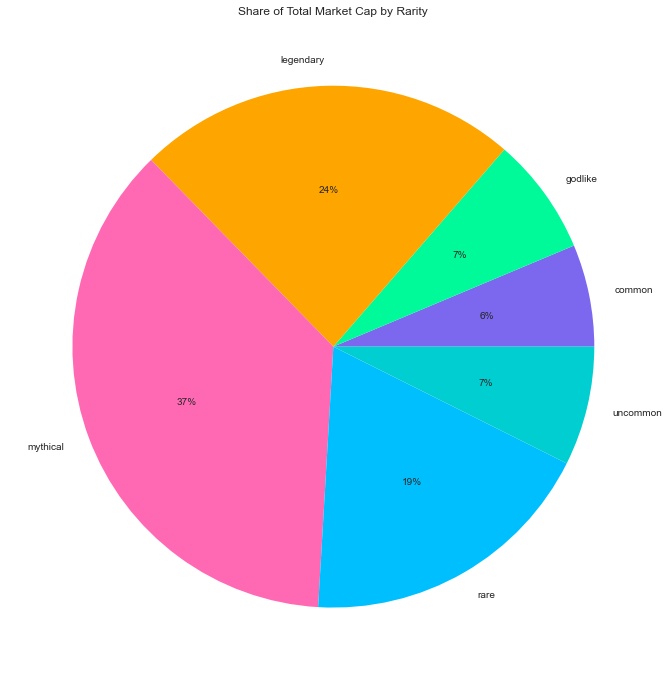

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
ax.set_title('Share of Total Market Cap by Rarity')
ax.pie(cap_by_rarity_df[column_name_mappings['marketCap']], labels=cap_by_rarity_df[column_name_mappings['rarity']], autopct='%.0f%%', colors=list(map(get_rarity_color, cap_by_rarity_df[column_name_mappings['rarity']].tolist()))
)
pass

## Wearables Supply

In [25]:
wearable_types_df['count']=1
column_name_mappings = {'name': 'Wearable', 'rarity': 'Rarity', 'slotNames': 'Slot(s)', 'maxQuantity': 'Total Supply', 'count': 'Total Count'}

def get_supply_by_column(column_name):
    return wearable_types_df.pivot_table(index=column_name,values='maxQuantity',aggfunc=np.sum,margins=False).reset_index()
def get_num_wearables_by_column(column_name):
    return wearable_types_df.pivot_table(index=column_name,values='count',aggfunc=np.sum,margins=False).reset_index()
def get_supply_and_count_by_column(column_name):
    return get_supply_by_column(column_name).join(get_num_wearables_by_column(column_name)['count']).rename(columns=column_name_mappings)



total_supply_df = pd.DataFrame({column_name_mappings['maxQuantity']: [np.sum(wearable_types_df['maxQuantity'])], column_name_mappings['count']: [np.count_nonzero(wearable_types_df['count'])]})
supply_by_name_df = get_supply_and_count_by_column('name')
supply_by_slot_df = get_supply_and_count_by_column('slotNames')
supply_by_rarity_df = get_supply_and_count_by_column('rarity')
supply_column = column_name_mappings['maxQuantity']
rarity_column = column_name_mappings['rarity']
proportion_of_rarity_column = 'Proportion of Rarity'
slot_column = column_name_mappings['slotNames']
supply_by_rarity_df[proportion_of_rarity_column] = supply_by_rarity_df.apply(lambda row: row[supply_column] / supply_by_rarity_df[supply_column].sum() * 100, axis=1)
supply_by_slot_rarity_df = get_supply_and_count_by_column(['slotNames', 'rarity'])
supply_by_slot_rarity_df[proportion_of_rarity_column] = supply_by_slot_rarity_df.apply(lambda row: row[supply_column] / supply_by_rarity_df[supply_by_rarity_df[rarity_column] == row[rarity_column]][supply_column].sum() * 100, axis=1)
get_supply_df_by_trait_effect = lambda trait: get_supply_and_count_by_column(['{t} Effect'.format(t=trait)]).replace('', np.NaN).dropna()
metrics=[column_name_mappings['maxQuantity'], column_name_mappings['count']]

### Total Wearable Supply

In [26]:
show_itable(total_supply_df)

### Wearables Supply by Slot

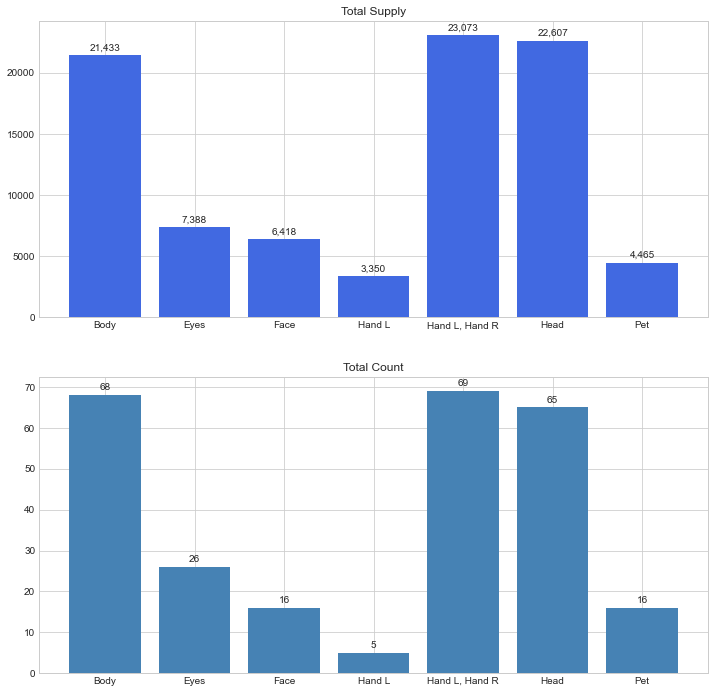

In [27]:
fig, axes = plt.subplots(len(metrics))
fig.set_size_inches(12,12)
for row in range(0,len(metrics)):
    m = metrics[row]
    ax = axes[row]
    color = ['royalBlue', 'steelBlue'][row]
    annotate_bars(ax.bar(supply_by_slot_df[column_name_mappings['slotNames']], supply_by_slot_df[m], color=color), ax)
    ax.set_title('{m}'.format(m=m))


### Wearables Supply by Rarity

In [28]:
show_itable(supply_by_rarity_df, order=[[1, 'desc']], column_formats={'Proportion of Supply': '{:,.3f} %'}) 

### Wearables Supply by Slot & Rarity

In [29]:
show_itable_long(supply_by_slot_rarity_df, order=[[0, 'asc'],[2, 'desc']], column_formats={'Proportion of Rarity': '{:,.1f} %'})

### Slot Proportion of Rarity

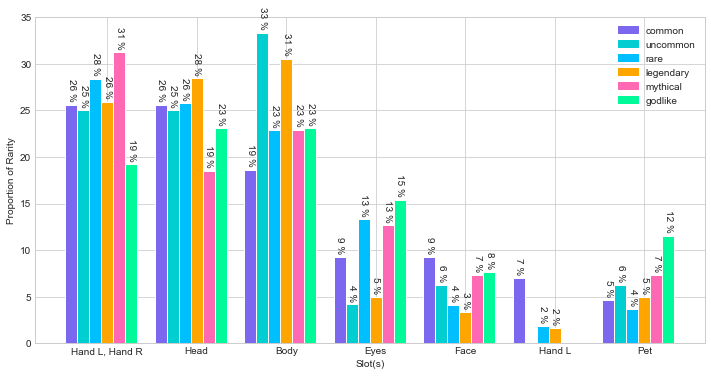

In [30]:
%%capture --no-display
# hide the warning about bar color and edge color

proportion_of_rarity_chart = GroupedBarChart(
    supply_by_slot_rarity_df.sort_values(supply_column, ascending=False),
    x_column_name=slot_column,
    y_column_name=proportion_of_rarity_column,
    series_column_name=rarity_column,
    series_colors=rarity_color_mappings)
proportion_of_rarity_chart.annotate_bars(annotation_format='{:.0f} %', rotation=-90)
proportion_of_rarity_chart.show()

## Wearables Usage for Rarity Farming
Based on the first rarity farming snapshot of each season.

### Equipped Rate by Season
Share of the total supply of wearables equipped to gotchis

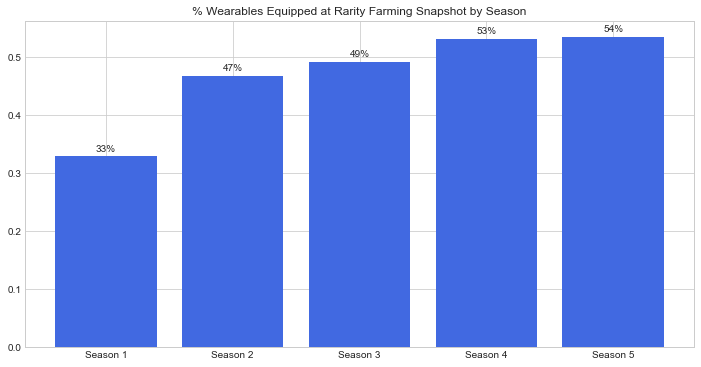

In [31]:
fig, ax = plt.subplots()
ax.set_title("% Wearables Equipped at Rarity Farming Snapshot by Season")
fig.set_size_inches(12,6)
rf_equipped_columns = []
bar_columns = []
bar_values = []
for i in range(0,len(RARITY_FARMING_BLOCKS)):
    equipped_column_name = 'equippedCount_rf' + str(i + 1)
    rf_equipped_columns += [equipped_column_name]
    rf_season_equipped_total = wearable_equipped_df[wearable_equipped_df[equipped_column_name] > 0][[equipped_column_name, 'maxQuantity']].sum()
    rf_season_equipped_total['equippedRate'] = (rf_season_equipped_total[equipped_column_name] / rf_season_equipped_total['maxQuantity'])
    bar_columns += ['Season {s}'.format(s=str(i + 1))]
    bar_values += [rf_season_equipped_total['equippedRate']]
annotate_bars(ax.bar(bar_columns, bar_values, color=DEFAULT_COLOR), ax, format="{0:.0%}")
pass

### Unique Equippers
The number of unique wallets that own at least one gotchi with a wearable equipped

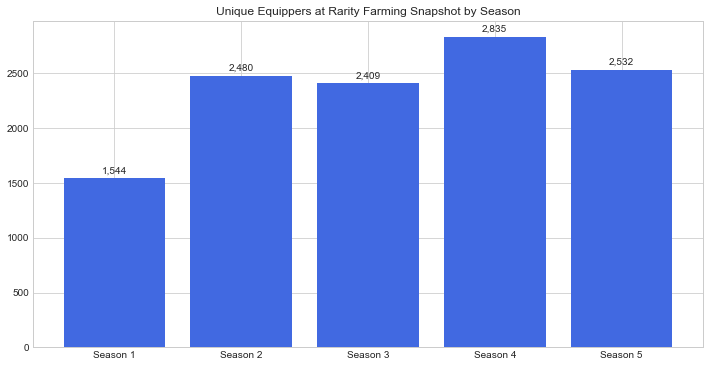

In [32]:
fig, ax = plt.subplots()
ax.set_title("Unique Equippers at Rarity Farming Snapshot by Season")
fig.set_size_inches(12,6)
annotate_bars(ax.bar(list(map(lambda s: 'Season {s}'.format(s=str(s)), wearable_owners_equipped_df.index.values)), wearable_owners_equipped_df['uniqueOwnersEquipped'], color=DEFAULT_COLOR), ax)
pass

In [33]:
column_name_mappings = {'name': 'Wearable', 'rarity': 'Rarity', 'slotNames': 'Slot(s)', 'maxQuantity': 'Total Supply', 'id': 'Total Count'}

def show_rf_equipped_by(agg_column_name):
    for i in range(0,len(RARITY_FARMING_BLOCKS)):
        rf_column_name = 'equippedCount_rf' + str(i + 1)
        mapped_column_name = 'Equipped RF Szn ' + str(i+1)
        def get_equipped_by_column(column_name):
            return wearable_equipped_df[wearable_equipped_df[rf_column_name] > 0].pivot_table(index=column_name,values=[rf_column_name, 'maxQuantity'],aggfunc=np.sum,margins=False).reset_index().rename(columns=column_name_mappings)
        column_name_mappings[rf_column_name] = mapped_column_name
        rf_season_equipped_df = get_equipped_by_column(agg_column_name)
        rf_season_equipped_df['Equipped Rate'] = (rf_season_equipped_df[mapped_column_name] / rf_season_equipped_df[column_name_mappings['maxQuantity']]).apply(lambda r: str(round(r * 100)) + '%')
        show_itable(rf_season_equipped_df, order=[1,'desc'], title='Season {s} &nbsp;&nbsp;<span style="font-size: 75%">(block #{b})<span>'.format(s=str(i+1), b=RARITY_FARMING_BLOCKS[i]))

### Equipped for Rarity Farming by Slot

In [34]:
show_rf_equipped_by('slotNames')

### Equipped for Rarity Farming by Rarity

In [35]:
show_rf_equipped_by('rarity')